#                      Backpropagation Learning Programming Assignment 


*   Write a program for the backpropagation algorithm.
*   No. of layers, No. of neurons and type of output function, in each layer can
be inputs.
*   Demonstrating training and testing for task of your choice. 





In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

### Loading MNIST Dataset

In [0]:

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

X, Y = fetch_openml('mnist_784', version=1, return_X_y=True)
Y = np.array(list(map(int, Y)))

one_idx = Y==1
zero_idx = Y==0
idx = np.logical_or(one_idx, zero_idx)
# print(len(one_idx), len(zero_idx), len(idx))
X = X[idx]
Y = Y[idx]


In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state=42)
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(9902, 784) (9902, 1)
(4878, 784) (4878, 1)


[1]


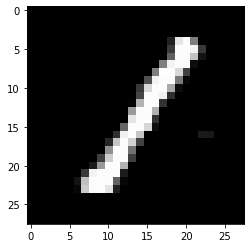

In [0]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0].reshape((28,28)))
print(y_train[0])

In [0]:
X_train = np.transpose(x_train/255)
Y_train = np.transpose(y_train)
X_test = np.transpose(x_test/255)
Y_test = np.transpose(y_test)
print ("\nTraining Input ->") 
print(X_train.shape)
print ("\nTraining Output ->") 
print(Y_train.shape)
print ("\nTesting Input ->") 
print(X_test.shape)
print ("\nTesting Output ->") 
print(Y_test.shape)


Training Input ->
(784, 9902)

Training Output ->
(1, 9902)

Testing Input ->
(784, 4878)

Testing Output ->
(1, 4878)


In [0]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
  
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

    

In [0]:
def initialize_parameters_deep(layer_dims):
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) 
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [0]:
parameters = initialize_parameters_deep([3,2,1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.93781623 -0.35319773 -0.3049401 ]
 [-0.61947872  0.49964333 -1.32879399]]
b1 = [[0.]
 [0.]]
W2 = [[ 1.23376823 -0.53825456]]
b2 = [[0.]]


## Forward propagation 

### Linear Forward
The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$. 

In [0]:
def linear_forward(A, W, b):
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [0]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

### L-Layer Model 

For even more convenience when implementing the $L$-layer Neural Net, we will need a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

In [0]:
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2    # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

## Cost function

Now We will implement forward and backward propagation. We need to compute the cost, because we want to check if our model is actually learning.

Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [0]:
def compute_cost(AL, Y):

    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

## Backward propagation 

Just like with forward propagation, you will implement helper functions for backpropagation. Remember that back propagation is used to calculate the gradient of the loss function with respect to the parameters. 








[Chain Rule](https://drive.google.com/open?id=1k4PyaKRlMNFnE2GHmpXhzU1NQbbBTaJU)

<caption><center> <br> *The purple blocks represent the forward propagation, and the red blocks represent the backward propagation.*  </center></caption>

### Linear backward

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. We want to get $(dW^{[l]}, db^{[l]} dA^{[l-1]})$.

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l]})$ are computed using the input $dZ^{[l]}$.Here are the formulas you need:
$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


In [0]:
def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

### Linear-Activation backward

Next, We create a function that merges the two helper functions: **`linear_backward`** and the backward step for the activation **`linear_activation_backward`**. 

To  implement `linear_activation_backward`, provided two backward functions:
- **`sigmoid_backward`**: Implements the backward propagation for SIGMOID unit. You can call it as follows:

```python
dZ = sigmoid_backward(dA, activation_cache)
```

- **`relu_backward`**: Implements the backward propagation for RELU unit. You can call it as follows:

```python
dZ = relu_backward(dA, activation_cache)
```

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) \tag{11}$$. 

In [0]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db


### L-Model Backward 

Now We implement the backward function for the whole network. We will iterate through all the hidden layers backward, starting from layer $L$. On each step, you will use the cached values for layer $l$ to backpropagate through layer $l$.

#### Initializing backpropagation:

To backpropagate through this network, we know that the output is, 
$A^{[L]} = \sigma(Z^{[L]})$. Your code thus needs to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
To do so, use this formula:
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```
$$grads["dW" + str(l)] = dW^{[l]}\tag{15} $$

In [0]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "sigmoid")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### Update Parameters

In this section We will update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

where $\alpha$ is the learning rate. After computing the updated parameters, store them in the parameters dictionary.

In [0]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters


## 5 - L-layer Neural Network


```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [0]:
### CONSTANTS ###
layers_dims = [784,20, 7, 5,1] #  L-layer model

In [0]:
def L_layer_model(X_train, Y_train, layers_dims, learning_rate = 0.05, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)
    
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        
        AL, caches = L_model_forward(X_train, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y_train)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y_train, caches)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        # print(parameters)
        # print("\n")
                
        # Print the cost every 100 training example
        if print_cost and i % 50 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 50 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.692425
Cost after iteration 50: 0.686714
Cost after iteration 100: 0.677010
Cost after iteration 150: 0.655827
Cost after iteration 200: 0.609800
Cost after iteration 250: 0.526424
Cost after iteration 300: 0.431368
Cost after iteration 350: 0.360715
Cost after iteration 400: 0.310368
Cost after iteration 450: 0.271352
Cost after iteration 500: 0.238207
Cost after iteration 550: 0.208913
Cost after iteration 600: 0.182844
Cost after iteration 650: 0.159716
Cost after iteration 700: 0.139383
Cost after iteration 750: 0.121865
Cost after iteration 800: 0.106888
Cost after iteration 850: 0.094225
Cost after iteration 900: 0.083518
Cost after iteration 950: 0.074430


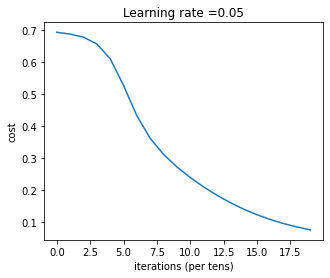

In [0]:
parameters = L_layer_model((X_train),(Y_train), layers_dims, num_iterations = 1000, print_cost = True) # Sigmoid Inside

In [0]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [0]:
pred_train = predict(X_train, Y_train, parameters)

Accuracy: 0.9867703494243584


In [0]:
pred_train = predict(X_test, Y_test, parameters)

Accuracy: 0.9874948749487495


Cost after iteration 0: 0.692425
Cost after iteration 50: 0.649152
Cost after iteration 100: 0.297155
Cost after iteration 150: 0.191365
Cost after iteration 200: 0.133559
Cost after iteration 250: 0.097384
Cost after iteration 300: 0.073499
Cost after iteration 350: 0.057208
Cost after iteration 400: 0.045781
Cost after iteration 450: 0.037550
Cost after iteration 500: 0.031469
Cost after iteration 550: 0.026859
Cost after iteration 600: 0.023286
Cost after iteration 650: 0.020462
Cost after iteration 700: 0.018191
Cost after iteration 750: 0.016342
Cost after iteration 800: 0.014808
Cost after iteration 850: 0.013522
Cost after iteration 900: 0.012430
Cost after iteration 950: 0.011492


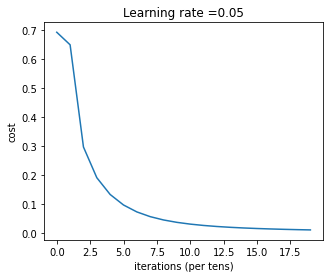

In [0]:
parameters = L_layer_model((X_train),(Y_train), layers_dims, num_iterations = 1000, print_cost = True) # Relu Inside

In [0]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p


In [0]:
pred_train = predict(X_train, Y_train, parameters)

Accuracy: 0.9984851545142392


In [0]:
pred_train = predict(X_test, Y_test, parameters)

Accuracy: 0.9993849938499385
